In [1]:
# Imports
import gc
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import statsmodels.formula.api as smf

# Set options
# Set seaborn style
sns.set_theme()  # (style="whitegrid")
warnings.filterwarnings("ignore")

# Set treatment date
treatment_date = datetime(2022, 11, 30)

## Loading the data

In [2]:
# 1. Data Preparation Function
def prepare_forum_data(forum_df, forum_name, so=False):
    """
    Prepare and standardize data from a Stack Exchange forum.

    Parameters:
    -----------
    forum_df : polars.DataFrame
        DataFrame containing Posts.xml data for a forum
    forum_name : str
        Name of the forum

    Returns:
    --------
    polars.DataFrame
        Standardized dataframe with question counts
    """

    needs_conversion = forum_df["CreationDate"].dtype != pl.Datetime

    # SO needs slightly different handling
    if so:
        questions_df = (
            forum_df
            # Conditionally convert CreationDate to datetime in the pipeline
            .with_columns(
                pl.col("CreationDate")
                .str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S.%f")
                .alias("CreationDate")
                if needs_conversion
                else pl.col("CreationDate"),
                # Add forum identifier
                pl.lit(forum_name).alias("forum"),
                pl.when(pl.col("tag_list").list.contains("python"))
                .then(pl.lit("Python"))
                .when(pl.col("tag_list").list.contains("r"))
                .then(pl.lit("R"))
                .when(pl.col("tag_list").list.contains("php"))
                .then(pl.lit("PHP"))
                .otherwise(pl.lit("JavaScript"))
                .alias("group"),
            )
        )
    else:
        questions_df = (
            forum_df
            # Conditionally convert CreationDate to datetime in the pipeline
            .with_columns(
                pl.col("CreationDate")
                .str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S.%f")
                .alias("CreationDate")
                if needs_conversion
                else pl.col("CreationDate"),
                # Add forum identifier
                pl.lit(forum_name).alias("forum"),
                # And group for stata and SO compatibility
                pl.lit(forum_name).alias("group"),
            )
        )

    questions_df = (
        questions_df.with_columns(
            pl.col("CreationDate").dt.date().alias("date"),
            pl.col("CreationDate").dt.year().alias("year"),
            pl.col("CreationDate").dt.month().alias("month"),
            pl.col("CreationDate").dt.weekday().alias("day_of_week"),
            # ISO week of year
            pl.col("CreationDate").dt.week().alias("week"),
        )
        # Create year-week identifier
        .with_columns((pl.col("year") * 100 + pl.col("week")).alias("yearweek"))
        # Add forum identifier
        .with_columns(pl.lit(forum_name).alias("forum"))
        # Aggregate to weekly level
        .group_by(["yearweek", "year", "week", "forum", "group"])
        .agg(
            pl.len().alias("question_count"),
            pl.col("date").min().alias("week_start"),
            # Optional: additional metrics if we want them
            # pl.col("Score").mean().alias("avg_score"),
            # pl.col("ViewCount").mean().alias("avg_views"),
            # pl.col("CommentCount").mean().alias("avg_comments"),
        )
        .with_columns(
            pl.when(pl.col("forum").eq("Stack Overflow"))
            .then(1)
            .otherwise(0)
            .alias("treated"),
        )
        # Drop first week and last two as they are non-representative
        .filter(
            pl.col("week_start") > datetime(2021, 1, 1),
            pl.col("week_start") <= datetime(2024, 3, 4),
        )
    )
    return questions_df


# 2. Load and prepare all forum data
# Load data
df_so = pl.read_parquet(
    "../data/batched_processing/stackoverflow_processed_batch.parquet"
)
# df_so = pl.read_parquet(
#    "../data/stackoverflow/stackoverflow.parquet"
# )  # Use this to get the overall effect of ChatGPT not only on scripting languages
stackoverflow_weekly = prepare_forum_data(df_so, "Stack Overflow", so=True)
# Clean memory
del df_so
gc.collect()
df_math = pl.read_parquet("../data/math/math.parquet")
df_physics = pl.read_parquet("../data/physics/physics.parquet")
df_superuser = pl.read_parquet("../data/superuser/superuser.parquet")
df_askubuntu = pl.read_parquet("../data/askubuntu/askubuntu.parquet")
math_weekly = prepare_forum_data(df_math, "Mathematics")
del df_math
physics_weekly = prepare_forum_data(df_physics, "Physics")
del df_physics
superuser_weekly = prepare_forum_data(df_superuser, "Superuser")
del df_superuser
askubuntu_weekly = prepare_forum_data(df_askubuntu, "Askubuntu")
del df_askubuntu
gc.collect()

# 3. Combine all forum data
all_forums_weekly = pl.concat(
    [
        stackoverflow_weekly,
        math_weekly,
        physics_weekly,
        superuser_weekly,
        askubuntu_weekly,
    ],
    how="diagonal_relaxed",
)

## Testing parallel trends assumption

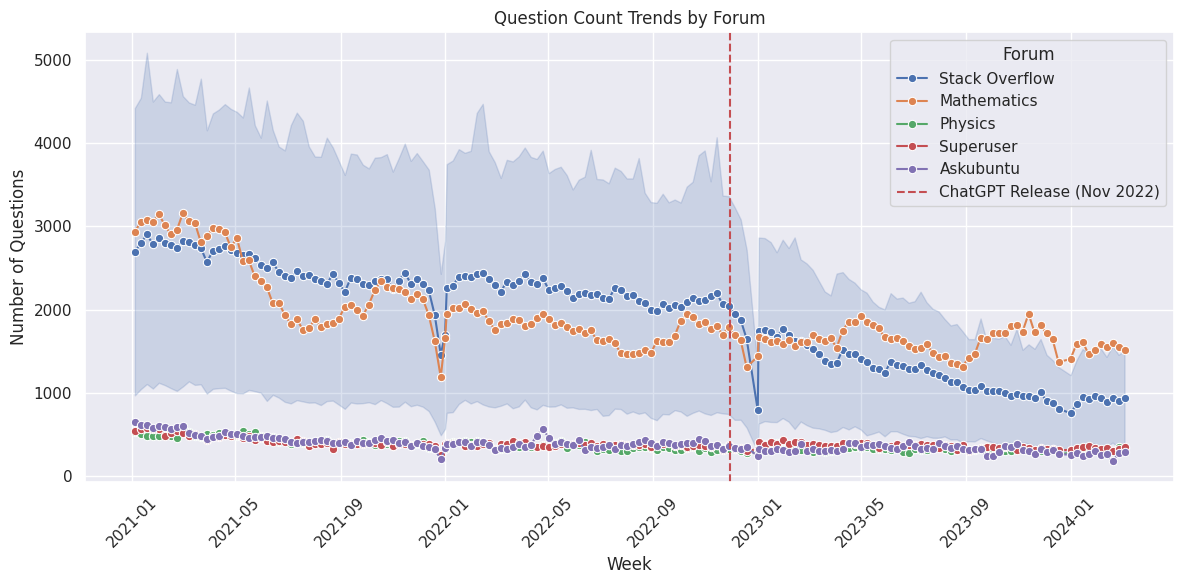

In [3]:
# 3. Visualize the data to check for parallel trends
plt.figure(figsize=(12, 6))

# Plot trends
sns.lineplot(
    data=all_forums_weekly,
    x="week_start",
    y="question_count",
    hue="forum",
    marker="o",
)

# Add vertical line for treatment date
plt.axvline(
    x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
)
plt.title("Question Count Trends by Forum")
plt.xlabel("Week")
plt.ylabel("Number of Questions")
plt.legend(title="Forum")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# 4. Addressing non-parallel trends: Log transformation for question counts
def transform_for_parallel(all_forums_weekly):
    """Apply transformations to help achieve more parallel trends"""
    # First, apply log transformation for question count
    transformed_df = all_forums_weekly.with_columns(
        pl.col("question_count")
        .map_elements(lambda x: np.log1p(x))
        .alias("log_question_count")
    )

    # Get all unique forums
    groups = transformed_df["group"].unique().to_list()

    # Create indexed count expressions for each forum
    indexed_exprs = []
    for group in groups:
        # Get the first period value for this forum
        first_value = (
            transformed_df.filter(pl.col("group") == group)
            .sort("week_start")
            .select(pl.col("question_count"))
            .head(1)
            .item()
        )

        # Add conditional expression for this forum
        indexed_exprs.append(
            pl.when(pl.col("group") == group)
            .then(100 * pl.col("question_count") / first_value)
            .otherwise(0)  # Will be overwritten by other forum conditions
        )

    # Combine all expressions with sum() to create the indexed_count column
    if indexed_exprs:
        final_expr = indexed_exprs[0]
        for expr in indexed_exprs[1:]:
            final_expr = final_expr + expr

        # Add the indexed column
        transformed_df = transformed_df.with_columns(final_expr.alias("indexed_count"))

    return transformed_df


# Apply transformation to question count
all_forums_weekly_transformed = transform_for_parallel(all_forums_weekly)

## Data dumps

Store data for regression and other analysis

In [5]:
# 5. Save data for Stata
# Data for Stata
def df_to_stata(df: pl.DataFrame, file_path: str) -> None:
    """Save a Polars DataFrame to Stata format"""

    df_stata = df.with_columns(
        pl.when(pl.col("week_start").gt(treatment_date))
        .then(1)
        .otherwise(0)
        .alias("treatment"),
        pl.when(
            pl.col("week_start").gt(treatment_date)
            & pl.col("forum").eq("Stack Overflow")
        )
        .then(1)
        .otherwise(0)
        .alias("treatment_synthdid"),
        # Weeks indexed
        pl.col("week_start").rank(method="dense").sub(1).alias("week_index"),
    )

    month_cont = (
        df.with_columns(
            # Month controls
            (
                pl.col("week_start").dt.year() * 100 + pl.col("week_start").dt.month()
            ).alias("year_month")
        )
        .select("year_month")
        .to_dummies(drop_first=True)
    )

    quarter_cont = (
        df.with_columns(
            # Quarter controls
            (
                pl.col("week_start").dt.year() * 10 + pl.col("week_start").dt.quarter()
            ).alias("year_quarter")
        )
        .select("year_quarter")
        .to_dummies(drop_first=True)
    )

    df_stata = pl.concat([df_stata, month_cont, quarter_cont], how="horizontal")

    df_stata.to_pandas().to_stata(file_path, write_index=False)


# Save Scripting language questions data for Stata
df_to_stata(all_forums_weekly_transformed, "../data/stata/so_script.dta")

# FIX: Save all questions data for Stata - doesn't contain the tag_list but only the tag string
# df_wo_so = all_forums_weekly_transformed.filter(pl.col("forum") != "Stack Overflow")
# df_all = transform_for_parallel(
#     prepare_forum_data(
#         pl.read_parquet("../data/stackoverflow/stackoverflow.parquet"),
#         "Stack Overflow",
#         so=True,
#     )
# )
# df_to_stata(pl.concat([df_all, df_wo_so]), "../data/stata/all_script.dta")

## Enhanced parallel trends

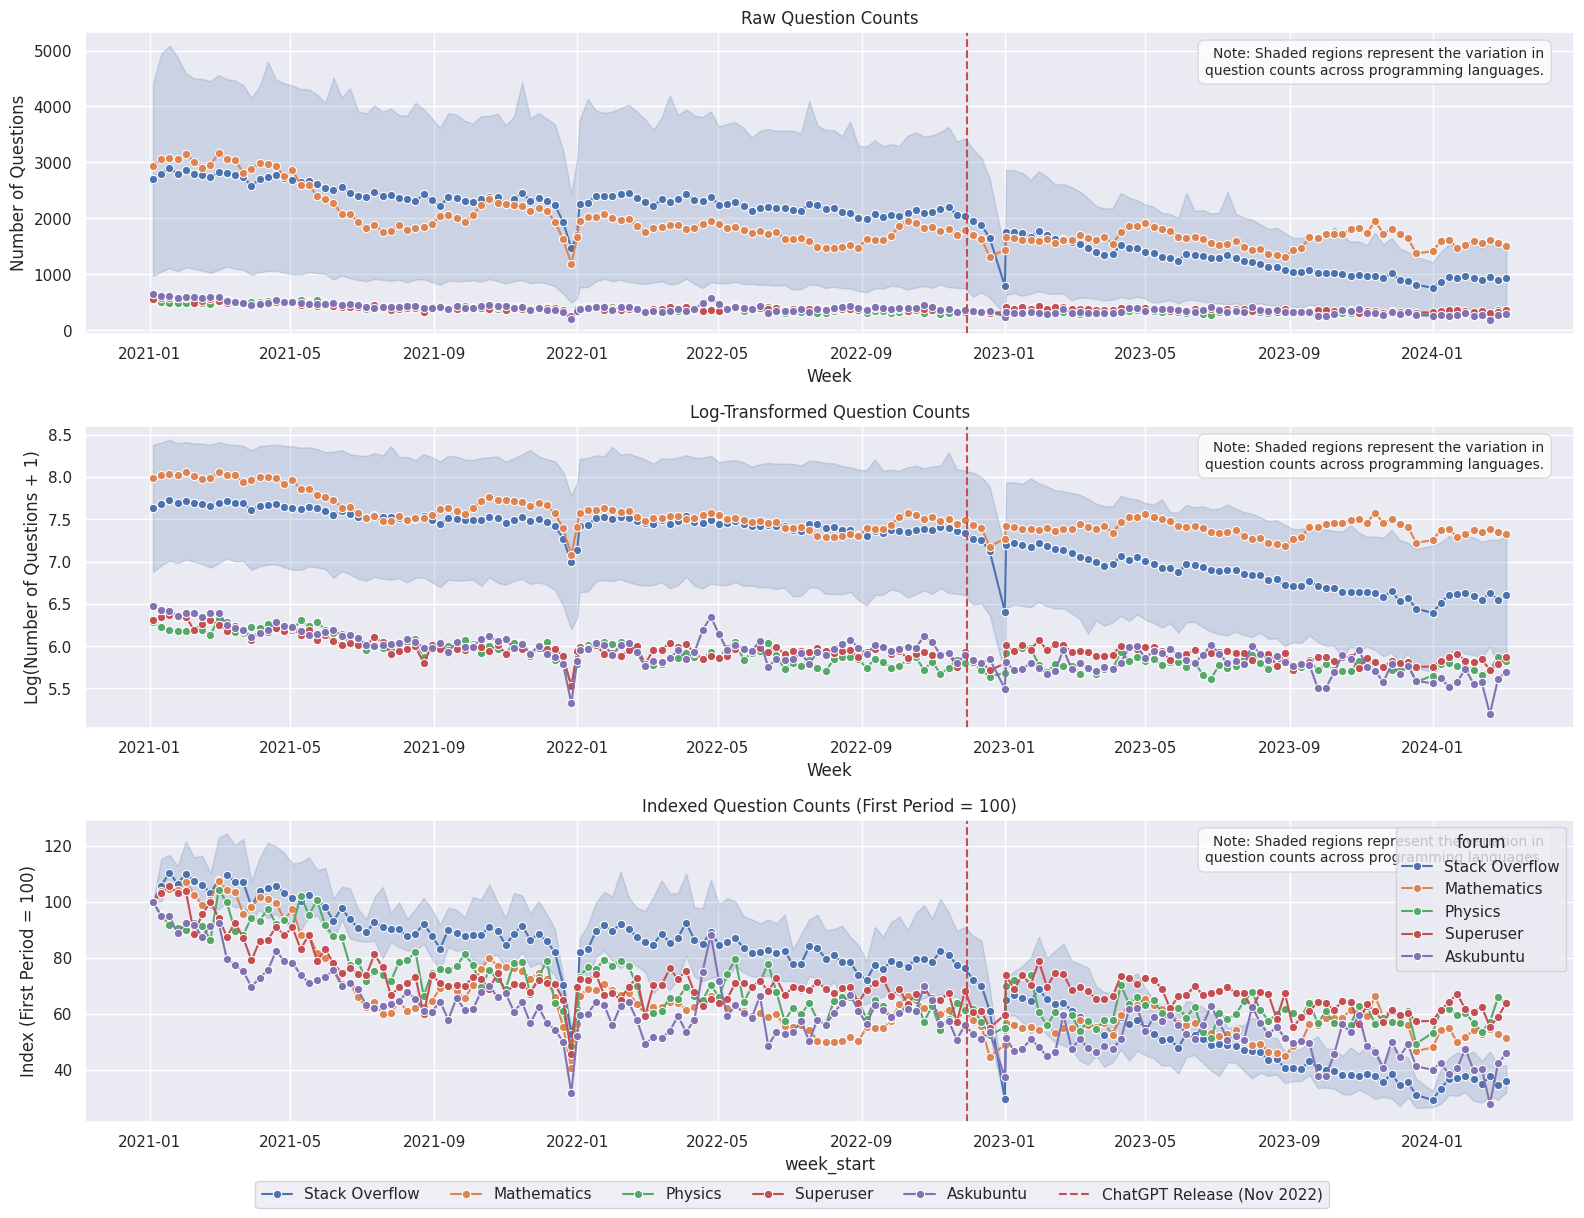

Parallel Trends Tests for Different Transformations:

Raw Counts:
time_trend:forum[T.Stack Overflow]: p = 0.9583 - Non-significant (parallel)
time_trend:forum[T.Mathematics]: p = 0.0415 - Significant (non-parallel)
time_trend:forum[T.Superuser]: p = 0.9326 - Non-significant (parallel)
time_trend:forum[T.Askubuntu]: p = 0.9705 - Non-significant (parallel)

Log Counts:
time_trend:forum[T.Stack Overflow]: p = 0.0323 - Significant (non-parallel)
time_trend:forum[T.Mathematics]: p = 0.6793 - Non-significant (parallel)
time_trend:forum[T.Superuser]: p = 0.5933 - Non-significant (parallel)
time_trend:forum[T.Askubuntu]: p = 0.7182 - Non-significant (parallel)

Indexed Counts:
time_trend:forum[T.Stack Overflow]: p = 0.0000 - Significant (non-parallel)
time_trend:forum[T.Mathematics]: p = 0.1332 - Non-significant (parallel)
time_trend:forum[T.Superuser]: p = 0.0725 - Non-significant (parallel)
time_trend:forum[T.Askubuntu]: p = 0.0696 - Non-significant (parallel)


In [ ]:
# 6. Visualize different transformations to check for better parallel trends
def visualize_transformations(transformed_data):
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    treatment_date = datetime(2022, 11, 30)

    # Plot 1: Raw question counts
    sns.lineplot(
        data=transformed_data,
        x="week_start",
        y="question_count",
        hue="forum",
        marker="o",
        ax=axes[0],
    )
    axes[0].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[0].set_title("Raw Question Counts")
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel("Number of Questions")
    axes[0].legend().remove()
    # axes[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=1)
    # Place legend below the plot
    # axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

    # Plot 2: Log-transformed question counts
    sns.lineplot(
        data=transformed_data,
        x="week_start",
        y="log_question_count",
        hue="forum",
        marker="o",
        ax=axes[1],
    )
    axes[1].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[1].set_title("Log-Transformed Question Counts")
    axes[1].set_xlabel("Week")
    axes[1].set_ylabel("Log(Number of Questions + 1)")
    axes[1].legend().remove()
    # axes[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), ncol=1)
    # Place legend below the plot
    # axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

    # Plot 3: Indexed question counts (first period = 100)
    sns.lineplot(
        data=transformed_data,
        x="week_start",
        y="indexed_count",
        hue="forum",
        marker="o",
        ax=axes[2],
    )
    axes[2].axvline(
        x=treatment_date, color="r", linestyle="--", label="ChatGPT Release (Nov 2022)"
    )
    axes[2].set_title("Indexed Question Counts (First Period = 100)")
    axes[2].set_ylabel("Index (First Period = 100)")
    axes[2].set_xlabel("Week")
    # Place legend below the plot
    # axes[2].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

    # Add note to each subplot
    for ax in axes:
        ax.annotate(
            "Note: Shaded regions represent the variation in\nquestion counts across programming languages.",
            xy=(0.98, 0.95),
            xycoords="axes fraction",
            ha="right",
            va="top",
            fontsize=10,
            bbox=dict(
                facecolor="white",
                alpha=0.8,
                edgecolor="lightgrey",
                boxstyle="round,pad=0.5",
            ),
        )

    # Add a single legend at the bottom of the figure
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=6, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()
    # plt.subplots_adjust(hspace=0.45)
    plt.savefig("../imgs/transformed_trends.svg")
    plt.show()

    return fig


# 8. Test for parallel trends with different transformations
def test_parallel_trends_transformed(transformed_data):
    """Test parallel trends assumption with different transformations"""
    # Convert to pandas for statsmodels
    transformed_data_pd = transformed_data.to_pandas()
    treatment_date = datetime(2022, 11, 30)

    # Filter to pre-treatment period
    pre_treatment = transformed_data_pd[
        transformed_data_pd["week_start"] <= treatment_date
    ].copy()

    # Create time trend variable
    pre_treatment["time_trend"] = pre_treatment.groupby("forum")["week_start"].rank()

    # Recode the forum variable to make Stack Overflow the reference
    pre_treatment["forum"] = pd.Categorical(
        pre_treatment["forum"],
        categories=[
            "Physics",
            "Stack Overflow",
            "Mathematics",
            "Superuser",
            "Askubuntu",
        ],
    )

    results = {}

    # Test raw counts
    formula_raw = "question_count ~ time_trend + forum + time_trend:forum"
    model_raw = smf.ols(formula_raw, data=pre_treatment).fit()
    results["Raw Counts"] = model_raw

    # Test log counts
    formula_log = "log_question_count ~ time_trend + forum + time_trend:forum"
    model_log = smf.ols(formula_log, data=pre_treatment).fit()
    results["Log Counts"] = model_log

    # Test indexed counts
    formula_idx = "indexed_count ~ time_trend + forum + time_trend:forum"
    model_idx = smf.ols(formula_idx, data=pre_treatment).fit()
    results["Indexed Counts"] = model_idx

    # Print summary of results
    print("Parallel Trends Tests for Different Transformations:")
    for name, model in results.items():
        print(f"\n{name}:")
        interactions = [var for var in model.params.index if "time_trend:forum" in var]
        p_values = model.pvalues[interactions]

        for var, p_val in zip(interactions, p_values):
            significance = (
                "Significant (non-parallel)"
                if p_val < 0.05
                else "Non-significant (parallel)"
            )
            print(f"{var}: p = {p_val:.4f} - {significance}")

    return results


# Testing parallel trends
visualize_transformations(all_forums_weekly_transformed)
parallel_tests = test_parallel_trends_transformed(all_forums_weekly_transformed)

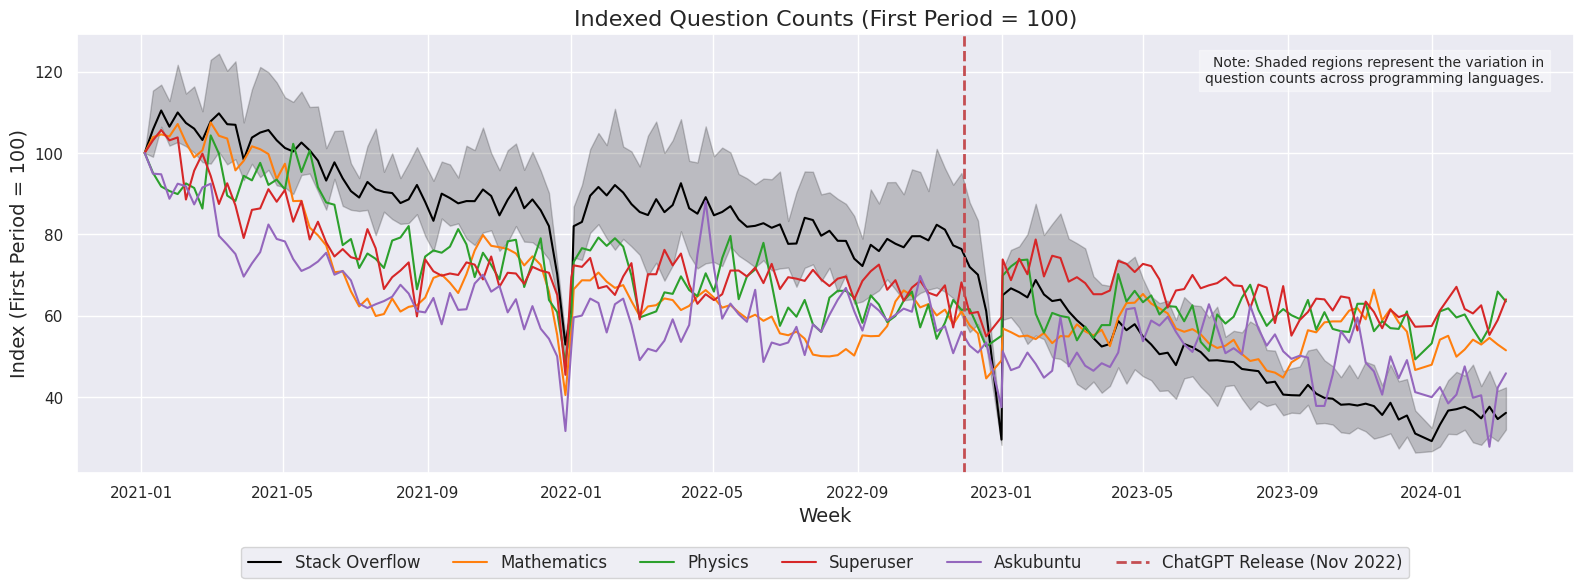

In [25]:
def visualize_indexed_trends(transformed_data):
    """
    Create a visualization of only the indexed question counts.

    Parameters:
    -----------
    transformed_data : polars.DataFrame
        DataFrame with transformed data including indexed_count column

    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the visualization
    """
    # Create figure with specified size
    fig, ax = plt.subplots(figsize=(16, 6))
    treatment_date = datetime(2022, 11, 30)

    # Define custom color palette with Stack Overflow as black
    custom_palette = {
        "Stack Overflow": "black",  # Stack Overflow as black
        "Mathematics": "#ff7f0e",  # Keep original colors for others
        "Physics": "#2ca02c",
        "Superuser": "#d62728",
        "Askubuntu": "#9467bd",
    }

    # Plot
    sns.lineplot(
        data=transformed_data,
        x="week_start",
        y="indexed_count",
        hue="forum",
        marker=None,
        palette=custom_palette,  # Apply the custom palette
        ax=ax,
    )

    # Add treatment date vertical line
    ax.axvline(
        x=treatment_date,
        color="r",
        linestyle="--",
        linewidth=2.0,
        label="ChatGPT Release (Nov 2022)",
    )

    # Set title and labels
    ax.set_title("Indexed Question Counts (First Period = 100)", fontsize=16)
    ax.set_ylabel("Index (First Period = 100)", fontsize=14)
    ax.set_xlabel("Week", fontsize=14)

    # Add annotation note
    ax.annotate(
        "Note: Shaded regions represent the variation in\nquestion counts across programming languages.",
        xy=(0.98, 0.95),
        xycoords="axes fraction",
        ha="right",
        va="top",
        fontsize=10,  # Smaller font
        bbox=dict(
            facecolor="white",
            alpha=0.4,  # Slightly more transparent
            edgecolor=None,  # Remove edge
            # boxstyle="round,pad=0.3",  # Smaller padding
        ),
    )
    # Format legend and place it below the plot
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=6,
        frameon=True,
        fontsize=12,
    )

    plt.subplots_adjust(bottom=0.2)  # Add more space at bottom for legend
    plt.tight_layout()
    plt.savefig("../imgs/indexed_trends.svg")
    plt.show()


# Call the function
visualize_indexed_trends(all_forums_weekly_transformed)

## Confirm parallel trends

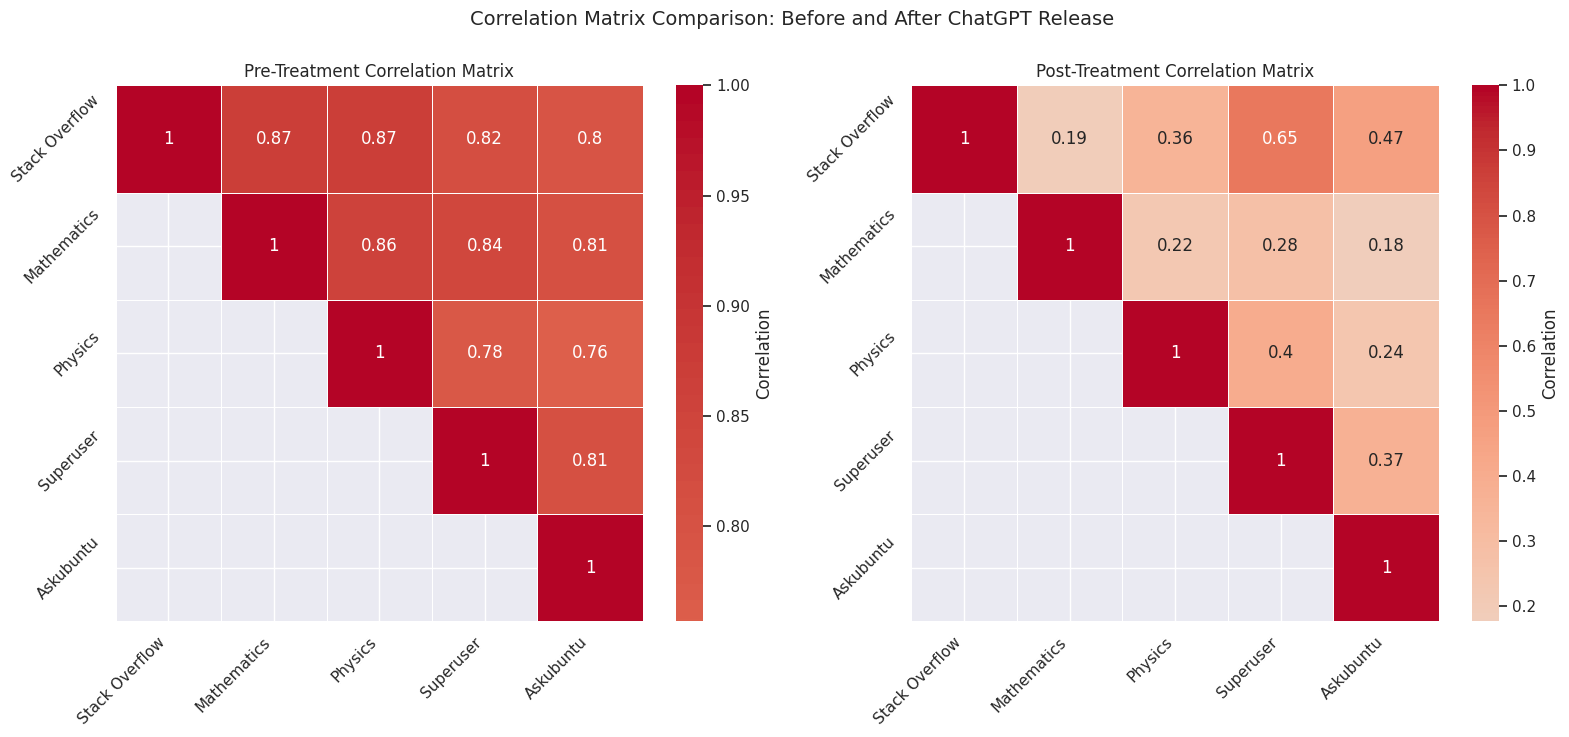

In [7]:
# 7. Create subfigures for pre-treatment and post-treatment correlation matrices

# sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

order = {
    "Stack Overflow": 0,
    "Mathematics": 1,
    "Physics": 2,
    "Superuser": 3,
    "Askubuntu": 4,
}

all_forums_weekly_transformed1 = (
    all_forums_weekly_transformed.group_by(["week_start", "forum"])
    .agg(pl.sum(["question_count", "log_question_count", "indexed_count"]))
    .with_columns(pl.col("forum").replace(order).alias("__order"))
    .sort("__order")
    .drop("__order")
    .pivot(
        on="forum",
        values=["question_count", "log_question_count", "indexed_count"],
    )
)

# Specify which transformation to use
cat = "log_question_count_"
correlation_cols = [x for x in all_forums_weekly_transformed1.columns if cat in x]
labels = [x.replace(cat, "") for x in correlation_cols]

# Pre-treatment correlation matrix
pre_data = all_forums_weekly_transformed1.filter(
    pl.col("week_start") <= treatment_date
).drop_nans()
pre_corr = pre_data.select(correlation_cols).corr()

mask = np.tril(np.ones_like(pre_corr.to_numpy()), k=-1)

sns.heatmap(
    pre_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[0],
    mask=mask,
)
axes[0].set_title("Pre-Treatment Correlation Matrix")

# Post-treatment correlation matrix
post_data = all_forums_weekly_transformed1.filter(
    pl.col("week_start") > treatment_date
).drop_nans()
post_corr = post_data.select(correlation_cols).corr()

sns.heatmap(
    post_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[1],
    mask=mask,
)
axes[1].set_title("Post-Treatment Correlation Matrix")

axes[0].set_xticklabels(labels, rotation=45, ha="right")
axes[1].set_xticklabels(labels, rotation=45, ha="right")
axes[0].set_yticklabels(labels, rotation=45, ha="right")
axes[1].set_yticklabels(labels, rotation=45, ha="right")

plt.tight_layout()
plt.suptitle(
    "Correlation Matrix Comparison: Before and After ChatGPT Release",
    y=1.05,
    fontsize=14,
)
plt.savefig("../imgs/pre-post_correlation_matrices.svg")
plt.show()

## Archive

In [8]:
# Data for pysynthdid
all_forums_weekly_transformed1 = all_forums_weekly_transformed.with_columns(
    pl.when(
        pl.col("week_start").gt(treatment_date) & pl.col("forum").eq("Stack Overflow")
    )
    .then(1)
    .otherwise(0)
    .alias("treatment")
)

all_forums_weekly_transformed1.write_parquet(
    "../data/all_forums_weekly_transformed.parquet"
)

In [9]:
# Data for SynapeML
synapseml = all_forums_weekly_transformed.with_columns(
    pl.col("week_start").gt(treatment_date).alias("treatment"),
    pl.when(pl.col("forum").eq("Stack Overflow")).then(1).otherwise(0).alias("outcome"),
)
synapseml.write_parquet("../data/synapseml.parquet")